# Temperature Modeling with **_Parametric Linear Regression_**

## Preparing the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import pandas as pd
from datetime import datetime as dt, timedelta as td
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import GridSearchCV

In [2]:
file_template = 'yosemite_village/CRNS0101-05-{year}-CA_Yosemite_Village_12_W.txt'

columns = ['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME', 'CRX_VN', 'LONGITUDE', 'LATITUDE',
           'AIR_TEMPERATURE', 'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE', 'ST_TYPE',
           'ST_FLAG', 'RELATIVE_HUMIDITY', 'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG',
           'WIND_1_5', 'WIND_FLAG']

years = list(range(2011, 2017))
data = pd.concat([pd.read_csv(file_template.format(year=y), sep=r'\s+', names=columns,
                              dtype=str)  # read as str to preserve leading 0s in date columns
                  for y in years], ignore_index=True)

data['DATE'] = pd.to_datetime(data.UTC_DATE + data.UTC_TIME, format='%Y%m%d%H%M')

data['AIR_TEMPERATURE'] = data.AIR_TEMPERATURE.astype('float64')

data = data[data.AIR_TEMPERATURE > -9999].copy()  # some missing values are -9999 for some reason

Since the most likely application of the model is predicting future temperature from past data, it makes more sense to use the first 4 years of the data for training and the 5th year for testing instead of doing random train/test split.

In [3]:
train_mask = data.DATE < '2016-01-01'
data_train = data[train_mask]
data_test = data[~train_mask]

And since the temperature undergoes both daily and yearly variations, we would split the date into two main features: the day in a year (ranging 1 to 356) and the minute in a day (ranging 0 to 1435 - given the 15-minute intervals of the data).

In [4]:
def split_date(dates):
    dates = pd.DatetimeIndex(dates)
    days = dates.dayofyear
    minutes = dates.minute + dates.hour * 60
    return np.asarray((days, minutes)).T

In [5]:
x_train = split_date(data_train.DATE)
y_train = data_train.AIR_TEMPERATURE.values

x_test = split_date(data_test.DATE)
y_test = data_test.AIR_TEMPERATURE.values

## Visualizing temperature variations

In order to apply the Radial Basis Kernel, we would need to understand where we should locate the centers of the functions, so we can look at how the temperature changes with respect to both day of the year and minute of the day.

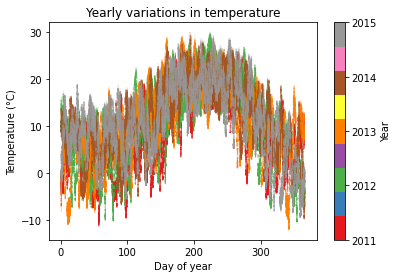

In [6]:
plt.scatter(x_train[:, 0], y_train, s=0.01, c=data_train.DATE.dt.year, cmap='Set1')
plt.colorbar(label='Year', ticks=np.unique(data_train.DATE.dt.year))
plt.xlabel('Day of year')
plt.ylabel('Temperature (°C)')
plt.title('Yearly variations in temperature')
plt.show()

So, for the day-of-year variations, it would make sense to put a center around 200 in order to capture the main annual fluctuation in temperature, as well as in the beginning and the end of range of values (0 and 356), and space a few others equally away from these three.

In order to better understand daily temperature variations, we should deseasonalize it by subtracting from each data point the average temperature of that day, which should make the trends in temperature more clear.

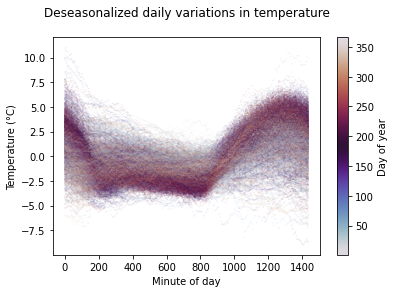

In [7]:
daily_avg_temp = pd.merge(data_train.assign(DAY=data_train.DATE.dt.normalize()),
                          data_train.groupby(by=pd.Grouper(key='DATE', freq='D')).mean().AIR_TEMPERATURE.rename(
                              'DAILY_AIR_TEMPERATURE'),
                          left_on='DAY', right_index=True).DAILY_AIR_TEMPERATURE.values

plt.scatter(x_train[:, 1], y_train - daily_avg_temp, c=x_train[:, 0], s=0.002, cmap='twilight')
plt.colorbar(label='Day of year')
plt.xlabel('Minute of day')
plt.ylabel('Temperature (°C)')
plt.title('Deseasonalized daily variations in temperature\n')
plt.show()

We can also plot the temperature in 3D being dependent on both time-of-day and day-of-year.

<IPython.core.display.Javascript object>


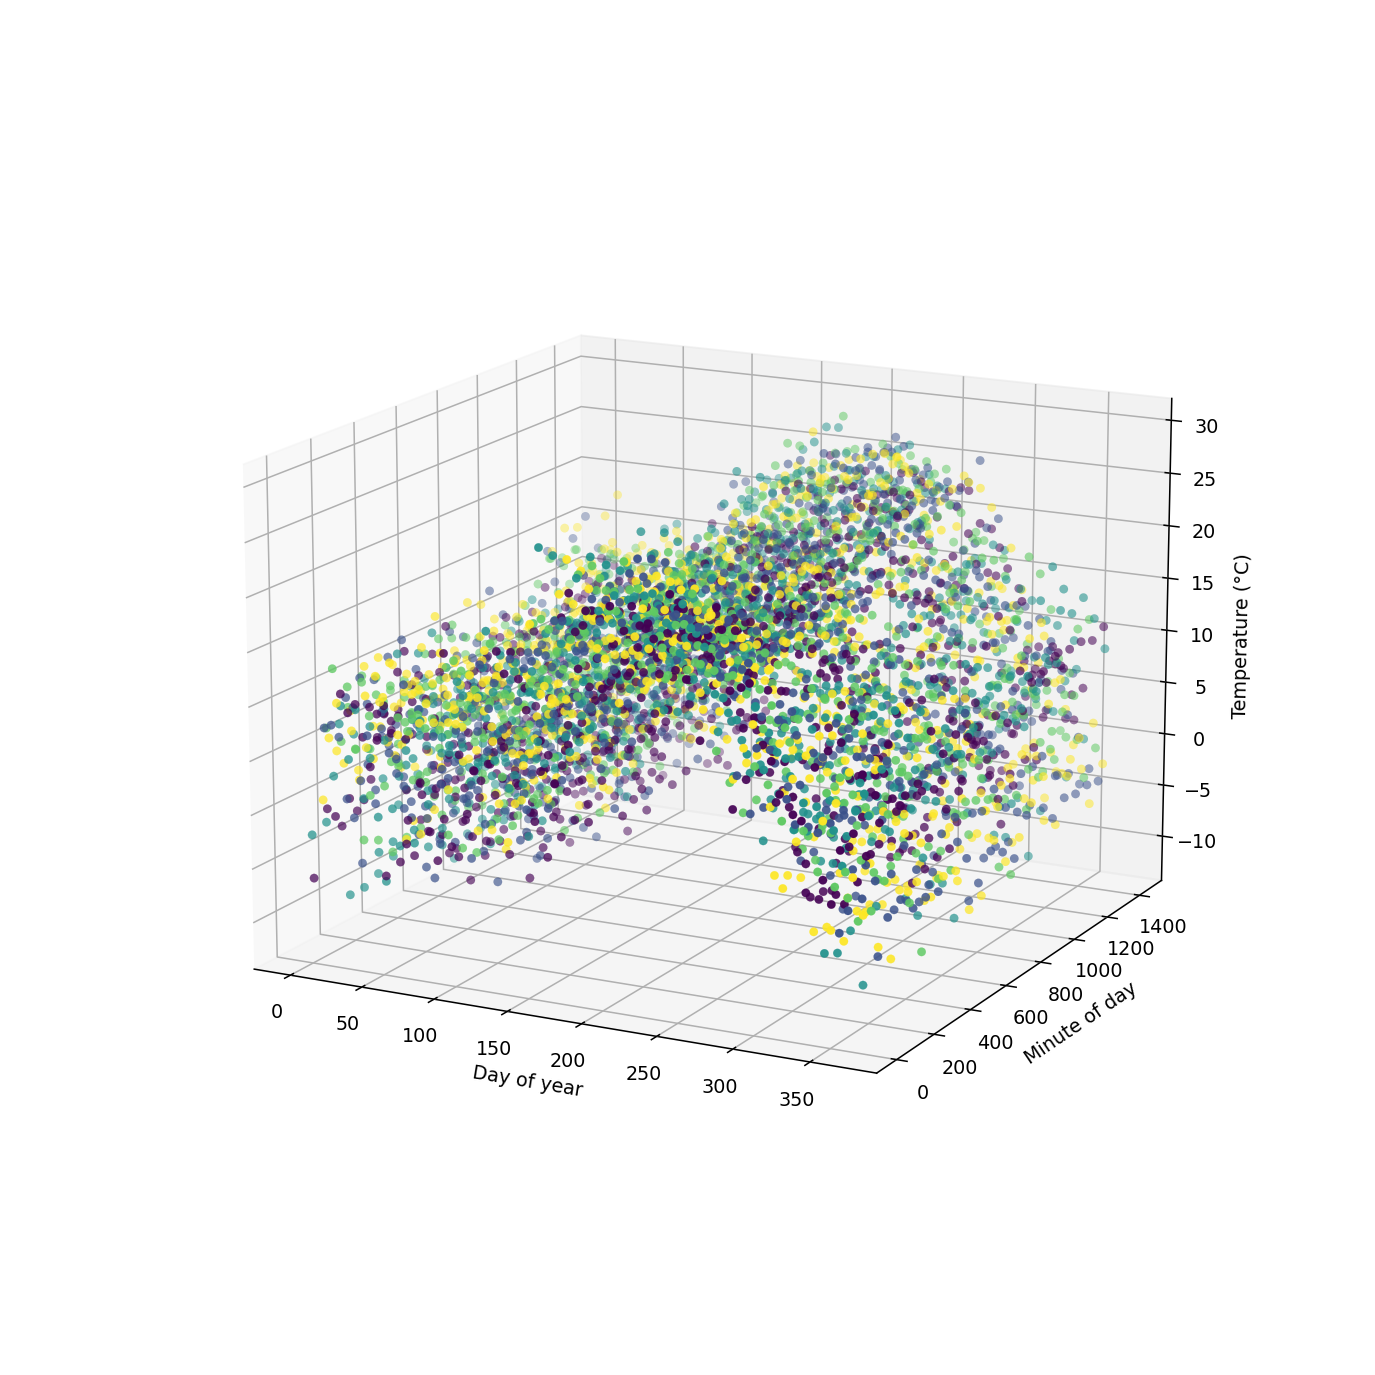

<Axes3DSubplot:xlabel='Day of year', ylabel='Minute of day'>

In [8]:
%matplotlib notebook
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_xlabel('Day of year')
ax.set_ylabel('Minute of day')
ax.set_zlabel('Temperature (°C)')
take_every = 100
ax.scatter(x_train[::take_every, 0], x_train[::take_every, 1], y_train[::take_every], 
           lw=0.1, c=data_train.DATE.dt.year.values[::take_every])
ax

## Setting up RBF

We can set sigma to be fairly large to capture the smoothness of the variations.

In [9]:
sigma = 1e5

centers = np.array(np.meshgrid(
    [1, 50, 100, 150, 200, 250, 300, 365],
    [0, 200, 400, 850, 1200, 1435],
)).T.reshape(-1, 2)


def get_rbf(x, sigma=sigma, centers=centers):
    scaling = np.array([1, x[:, 0].max() / x[:, 1].max()])
    return rbf_kernel(x * scaling, centers * scaling, gamma=1.0 / sigma)

## Modeling

In [10]:
alphas = [1e-10, 1e-5, 1e-1, 1e1, 1e2, 1e3]

x_train_rbf = get_rbf(x_train, sigma, centers)

grid_search = GridSearchCV(Ridge(), param_grid=dict(alpha=alphas))
grid_search.fit(x_train_rbf, y_train)

alpha = grid_search.best_params_['alpha']
print('Best alpha:', alpha)

Best alpha: 1e-10


Now we can look at the accuracy of the model on the training year if it takes into account only the yearly variations in temperature:

In [11]:
ridge_day = Ridge(alpha=alpha)
ridge_day.fit(rbf_kernel(x_train[:, :1], centers[:, :1], gamma=1 / sigma), y_train)

print("Yearly Test R² =", ridge_day.score(rbf_kernel(x_test[:, :1], centers[:, :1], gamma=1 / sigma), y_test))

Yearly Test R² = 0.5797587752282106


And if takes into account only the daily variations:

In [12]:
ridge_time = Ridge(alpha=alpha)
ridge_time.fit(rbf_kernel(x_train[:, 1:], centers[:, 1:], gamma=1 / sigma), y_train)

print("Daily Test R² =", ridge_time.score(rbf_kernel(x_test[:, 1:], centers[:, 1:], gamma=1 / sigma), y_test))

Daily Test R² = 0.04393261574595542


c:\users\breedoon\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.87951e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


And now we can combine them into a single model:

In [13]:
ridge_full = Ridge(alpha=alpha)
ridge_full.fit(x_train_rbf, y_train)

x_test_rbf = get_rbf(x_test, sigma, centers)
y_pred = ridge_full.predict(x_test_rbf)
print("Combined Test R² =", ridge_full.score(x_test_rbf, y_test))

Combined Test R² = 0.6309976116815921


And finally, we can visualize this model's prediction for the test year.

<IPython.core.display.Javascript object>


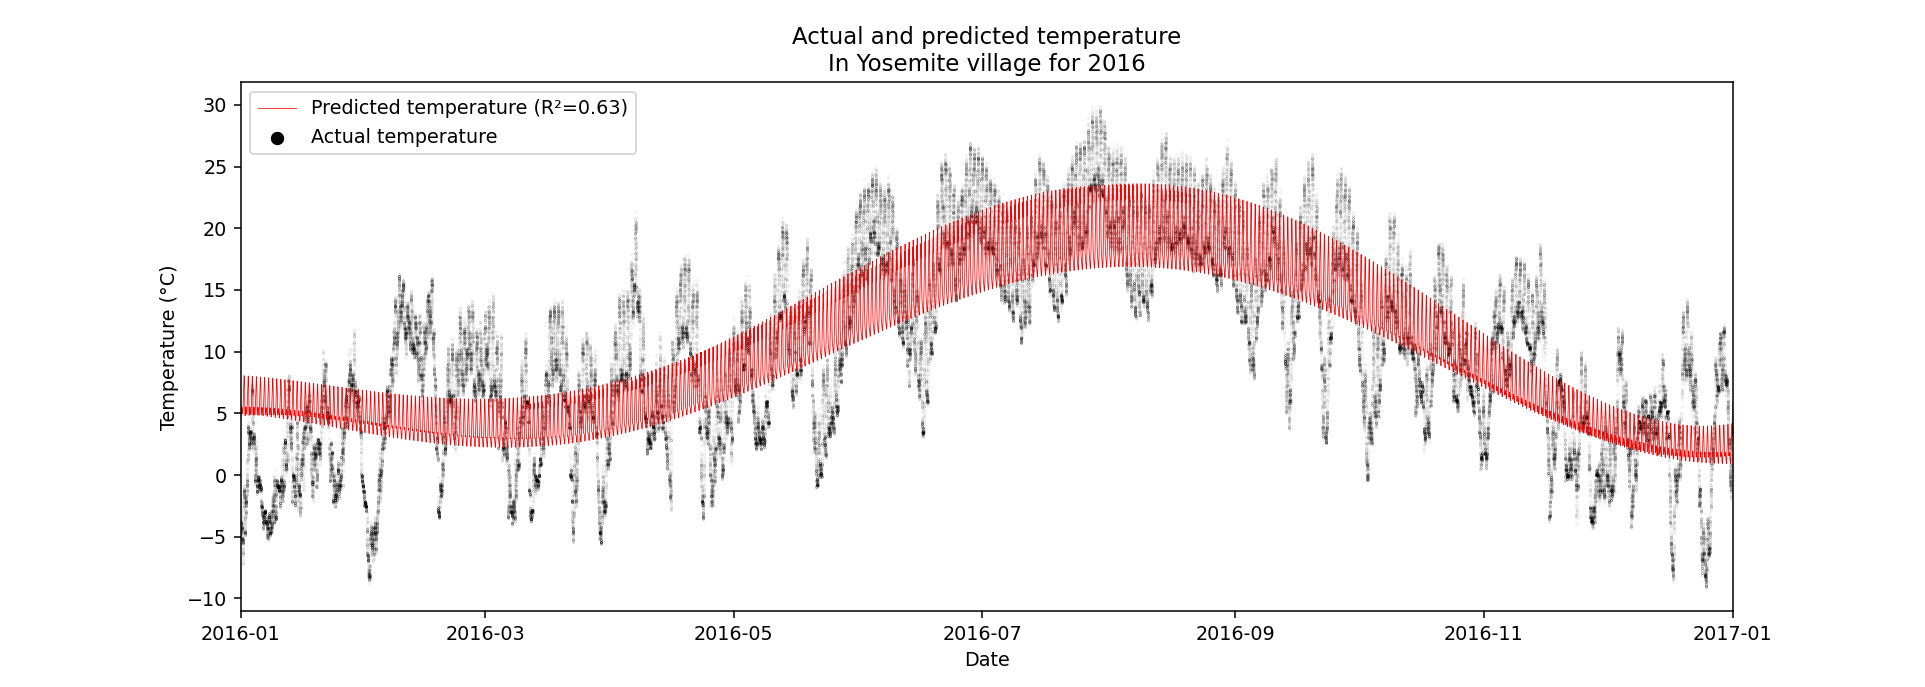

In [14]:
plt.figure(figsize=(14, 5))
plt.scatter(data_test.DATE, data_test.AIR_TEMPERATURE, color='k', s=0.001)
plt.plot(data_test.DATE, y_pred,
         label=f'Predicted temperature (R²={round(ridge_full.score(x_test_rbf, y_test), 2)})',
         color='red', lw=0.4)

plt.scatter([], [], c='k', label='Actual temperature')  # for legend
plt.legend(loc='upper left')
plt.title('Actual and predicted temperature\n'
          'In Yosemite village for 2016')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xlim(data_test.DATE.min(), data_test.DATE.max())
plt.show()